In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sqlite3
import utils as u
import numpy as np
import pandas as pd
import multiprocessing
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import product

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    precision_score,
    recall_score, 
    f1_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure
)

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)

n_jobs = multiprocessing.cpu_count() - 1
print(f"Using {n_jobs} CPU cores")

Using 15 CPU cores


In [2]:
if not os.path.exists("./data/data.db"):
    os.system("python3.11 build_db.py")

conn = sqlite3.connect("./data/data.db")
c = conn.cursor()


COLS_EXCLUDE = set([
    "StateAbbr",
    "StateDesc",
    "CountyName",
    "CountyFIPS",
    "TractFIPS",
    "fips",
    "stateabb",
    "sedaadmin",
    "sedaadminname",
    "TRACT",
    "COUNT"
])

if not os.path.exists("./data/full_joined_table.csv"):
    c.execute(f"""
    WITH seda_tracts AS (
        SELECT *
        FROM seda s
        JOIN nces n
        ON s.sedaadmin = n.LEAID
        WHERE s.year = 2019
    )

    , food_atlas_tracts AS (
        SELECT *
        FROM food f
        JOIN seda_tracts st
        ON st.TRACT = f.CensusTract
    )

    , cdc_tracts AS (
        SELECT *
        FROM cdc c
        JOIN food_atlas_tracts ft
        ON ft.TRACT = c.TractFIPS
    )

    SELECT *
    FROM cdc_tracts;
    """)

    rows = c.fetchall()
    print(len(rows))
    columns = [col[0] for col in c.description]

    ## Write the rows manually into a CSV file without pandas
    to_remove = [
        "StateAbbr",
        "CountyName",
        "TractFIPS",
        "stateabb",
        "MHLTH_CrudePrev:1",
        "SLEEP_CrudePrev:1",
        "fips",
        "LEAID",
        "NAME_LEA19",
        "TRACT",
        "COUNT"
    ]
    to_remove_idx = set([i for i, col in enumerate(columns) if col in to_remove])
    with open("data/full_joined_table.csv", "w") as f:
        race_cols = []
        f.write(",".join([col for i, col in enumerate(columns) if i not in to_remove_idx]) + "\n")
        for row in tqdm(rows):
            # if row[0] == "CA":
            f.write(",".join([str(x) for i, x in enumerate(row) if i not in to_remove_idx]) + "\n")


In [3]:
df = pd.read_csv("data/full_joined_table.csv")
print(df.shape)
df.head()

(995894, 68)


,MHLTH_CrudePrev,SLEEP_CrudePrev,CensusTract,State,County,Urban,LATracts_half,LATracts10,PovertyRate,LowIncomeTracts,...,tot_asmt_whg,gcs_mn_wht,gcs_mn_se_wht,tot_asmt_wht,gcs_mn_wng,gcs_mn_se_wng,tot_asmt_wng,last_bie,LANDAREA,WATERAREA
0,18.6,36.9,1095030701,Alabama,Marshall County,0,0,0,26.0,1,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,2.116012,0.000000
1,18.9,37.3,1095030702,Alabama,Marshall County,0,0,0,15.2,0,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,0.800889,0.009930
2,19.5,38.4,1095030801,Alabama,Marshall County,1,1,0,29.9,1,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,5.437714,0.012075
3,21.9,40.2,1095030802,Alabama,Marshall County,1,1,0,39.2,1,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,5.297315,0.017784
4,15.8,35.2,1095030902,Alabama,Marshall County,1,1,0,13.7,0,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,7.293396,0.033274


<Axes: >

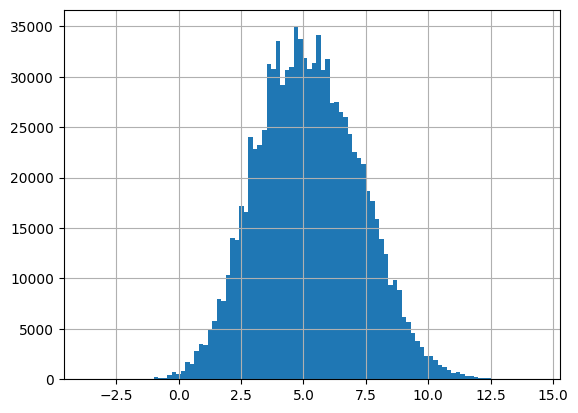

In [4]:
df.gcs_mn_all.hist(bins=100)

<Axes: >

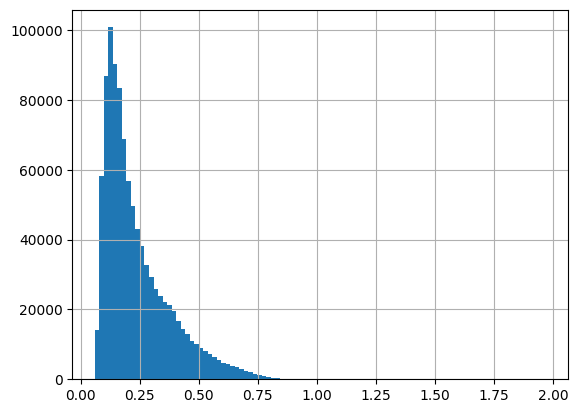

In [5]:
df.gcs_mn_se_all.hist(bins=100)

In [6]:
meta_data_cols = [
    "CensusTract",
    "State",
    "County",
    "sedaadmin",
    "sedaadminname",
    "subject",
    "grade"
]

health_feature_cols = [
    "MHLTH_CrudePrev", # cont
    "SLEEP_CrudePrev", # cont
]

food_desert_cols = [
    "Urban",            # bool
    "LATracts_half",    # bool
    "LATracts10",       # bool
    "PovertyRate",      # cont
    "LowIncomeTracts",  # bool
    "lahunvhalfshare",  # bool
    "lahunv10share",    # bool
]

academics_all_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_ecd", "gcs_mn_se_ecd", "tot_asmt_ecd",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
    "gcs_mn_mfg", "gcs_mn_se_mfg", "tot_asmt_mfg",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
    "gcs_mn_nec", "gcs_mn_se_nec", "tot_asmt_nec",
    "gcs_mn_neg", "gcs_mn_se_neg", "tot_asmt_neg",
    "gcs_mn_wag", "gcs_mn_se_wag", "tot_asmt_wag",
    "gcs_mn_wbg", "gcs_mn_se_wbg", "tot_asmt_wbg",
    "gcs_mn_whg", "gcs_mn_se_whg", "tot_asmt_whg",
    "gcs_mn_wht", "gcs_mn_se_wht", "tot_asmt_wht",
    "gcs_mn_wng", "gcs_mn_se_wng", "tot_asmt_wng",
]

academics_race_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_wht", "gcs_mn_se_wht", "tot_asmt_wht",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
]

academics_gender_cols = [
    # "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
]

**Classification/clustering by race**

In [7]:
# Exclude lahunv10share since it is mostly NaN
feature_cols = academics_all_cols + health_feature_cols
race_df = df[academics_all_cols + health_feature_cols + food_desert_cols[:-1] + meta_data_cols].copy()
print(f"Original length: {len(race_df)}")
race_df = race_df.dropna().reset_index(drop=True)
race_df["y"] = race_df.apply(lambda row: str(row["Urban"]) + str(row["LATracts_half"]), axis=1)
print(f"Length after dropping NaNs: {len(race_df)}")
race_df.head()

Original length: 995894
Length after dropping NaNs: 94513


,gcs_mn_all,gcs_mn_se_all,tot_asmt_all,gcs_mn_asn,gcs_mn_se_asn,tot_asmt_asn,gcs_mn_blk,gcs_mn_se_blk,tot_asmt_blk,gcs_mn_ecd,...,LowIncomeTracts,lahunvhalfshare,CensusTract,State,County,sedaadmin,sedaadminname,subject,grade,y
0,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,1,17.76,1089000201,Alabama,Madison County,102220,Madison County,mth,3,00
1,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,1,4.06,1089000403,Alabama,Madison County,102220,Madison County,mth,3,11
2,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,0,6.85,1089000901,Alabama,Madison County,102220,Madison County,mth,3,11
3,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,0,0.49,1089001401,Alabama,Madison County,102220,Madison County,mth,3,11
4,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,1,4.24,1089001402,Alabama,Madison County,102220,Madison County,mth,3,11


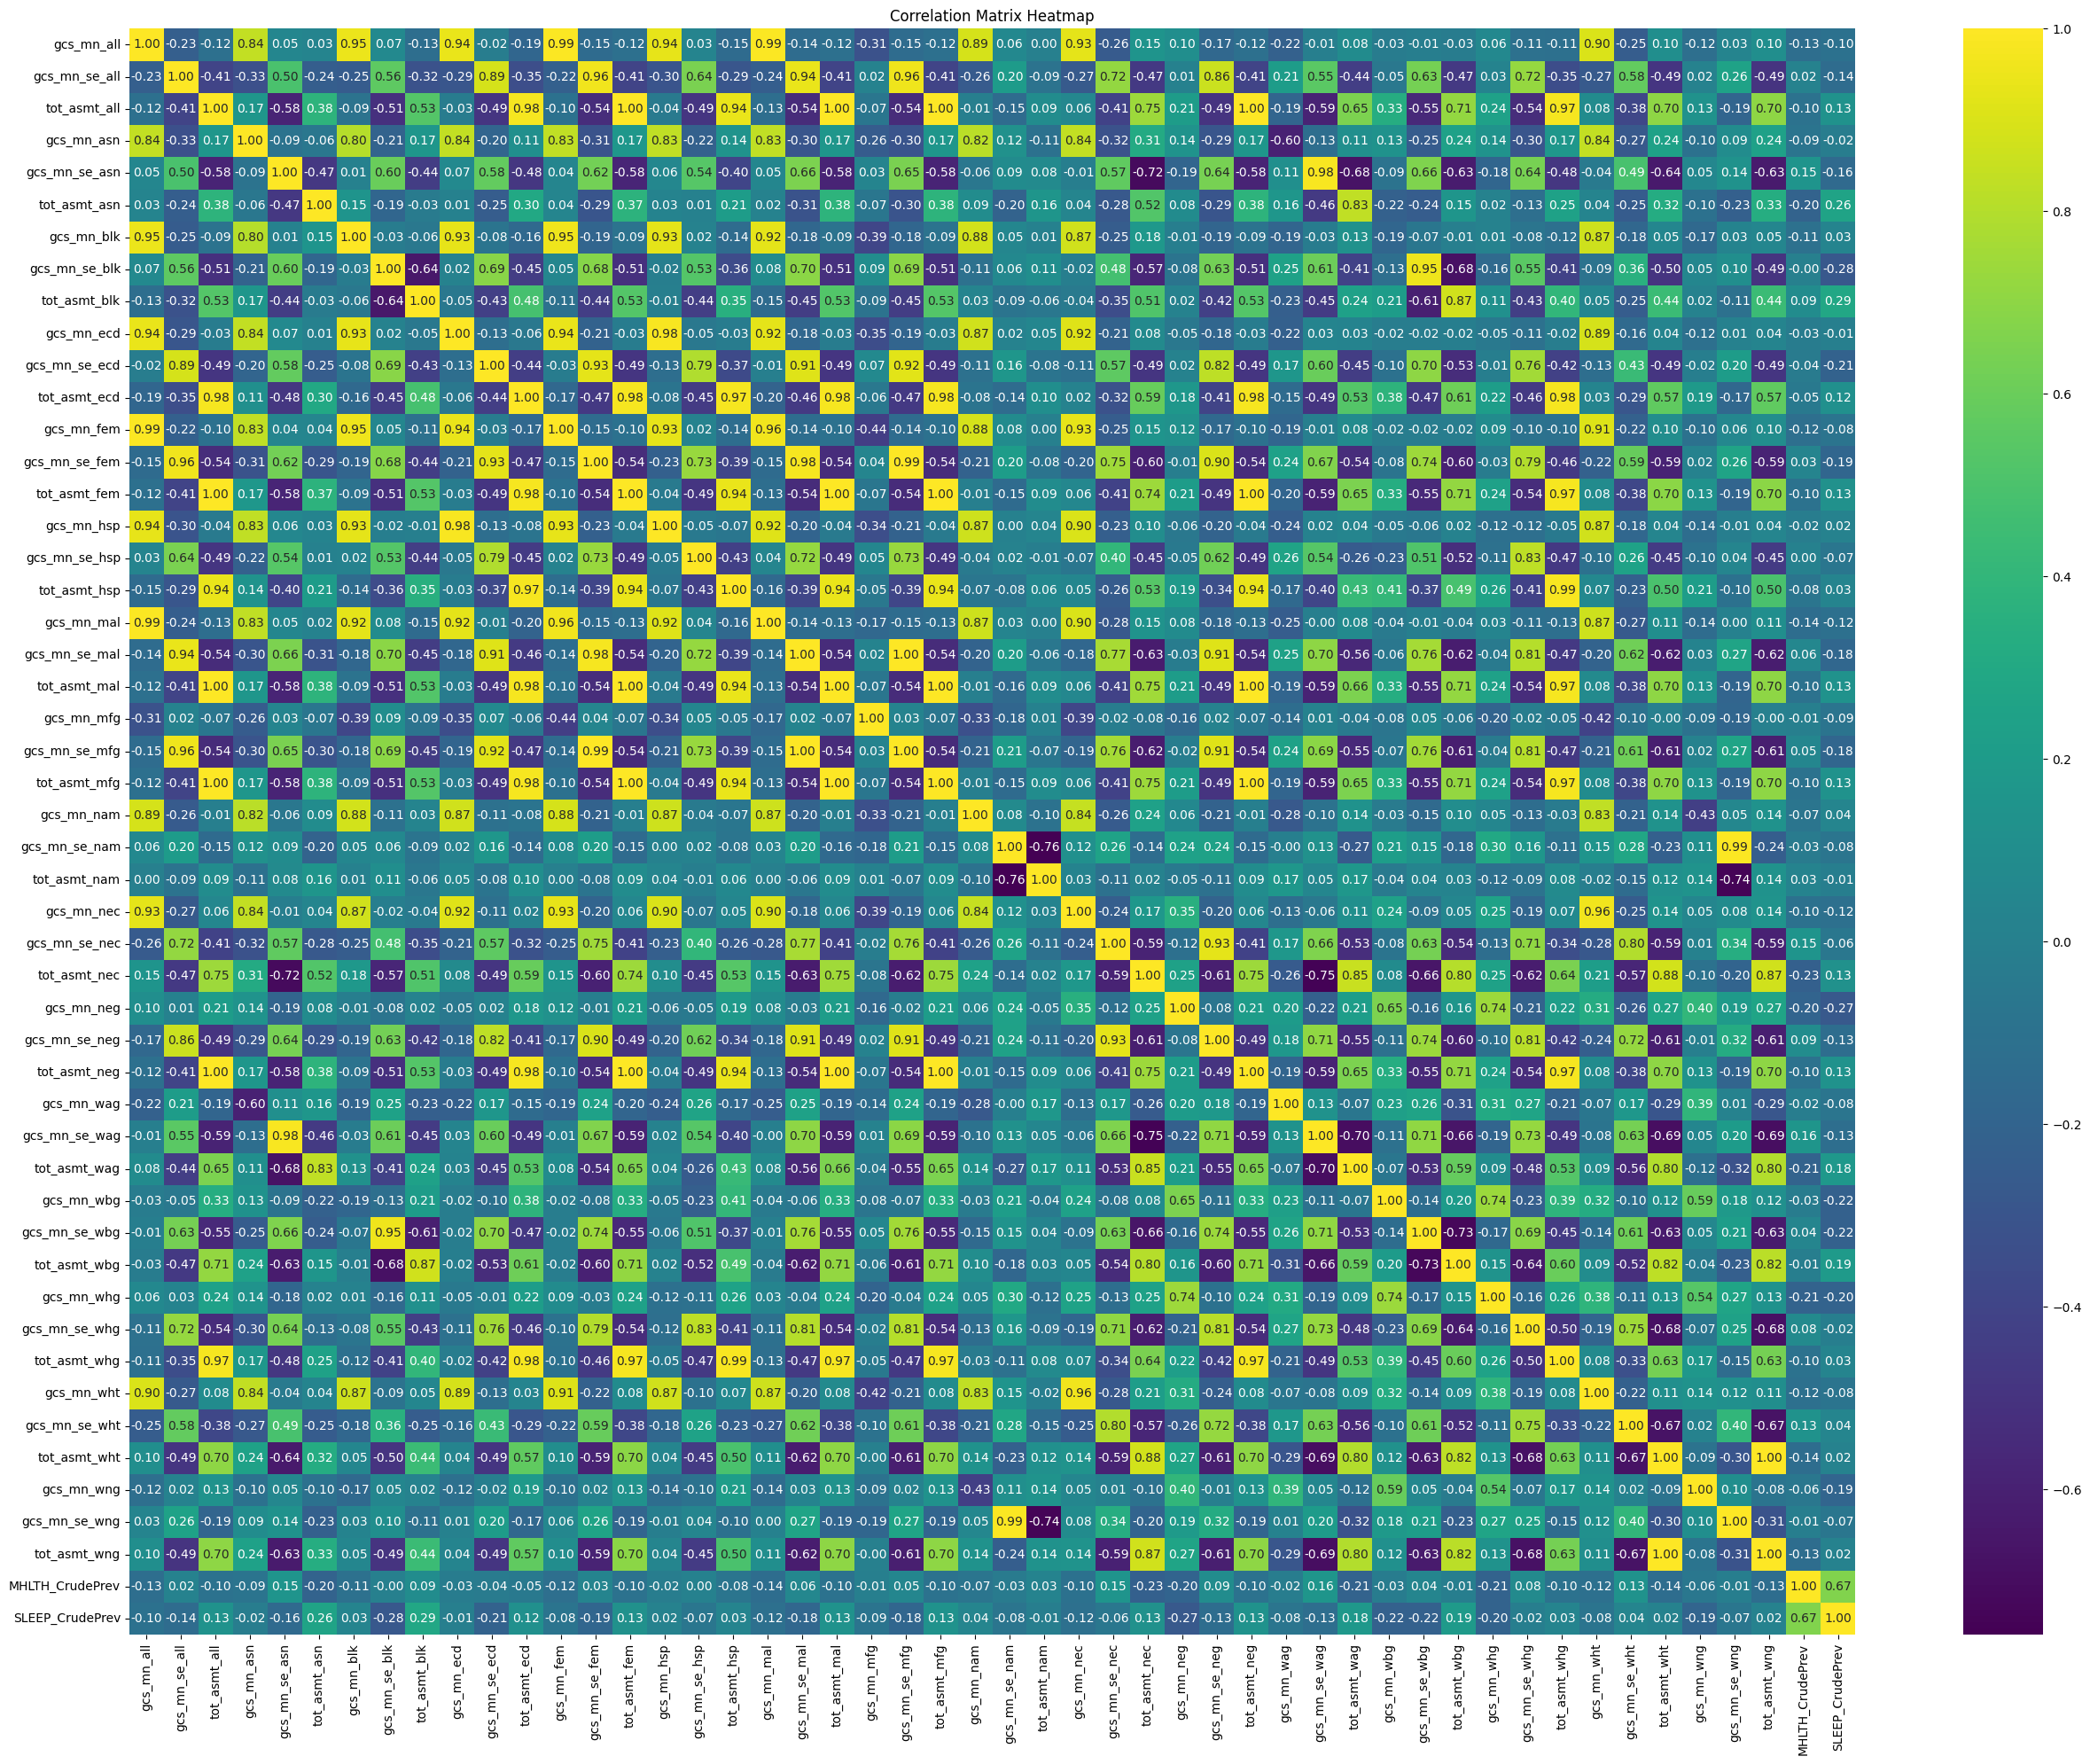

In [11]:
corr_map = race_df[feature_cols].corr()
plt.figure(figsize=(26, 20))
sns.heatmap(corr_map, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.savefig("analysis_deliverable/visualizations/feature_correlation_heatmap.png")
plt.show()

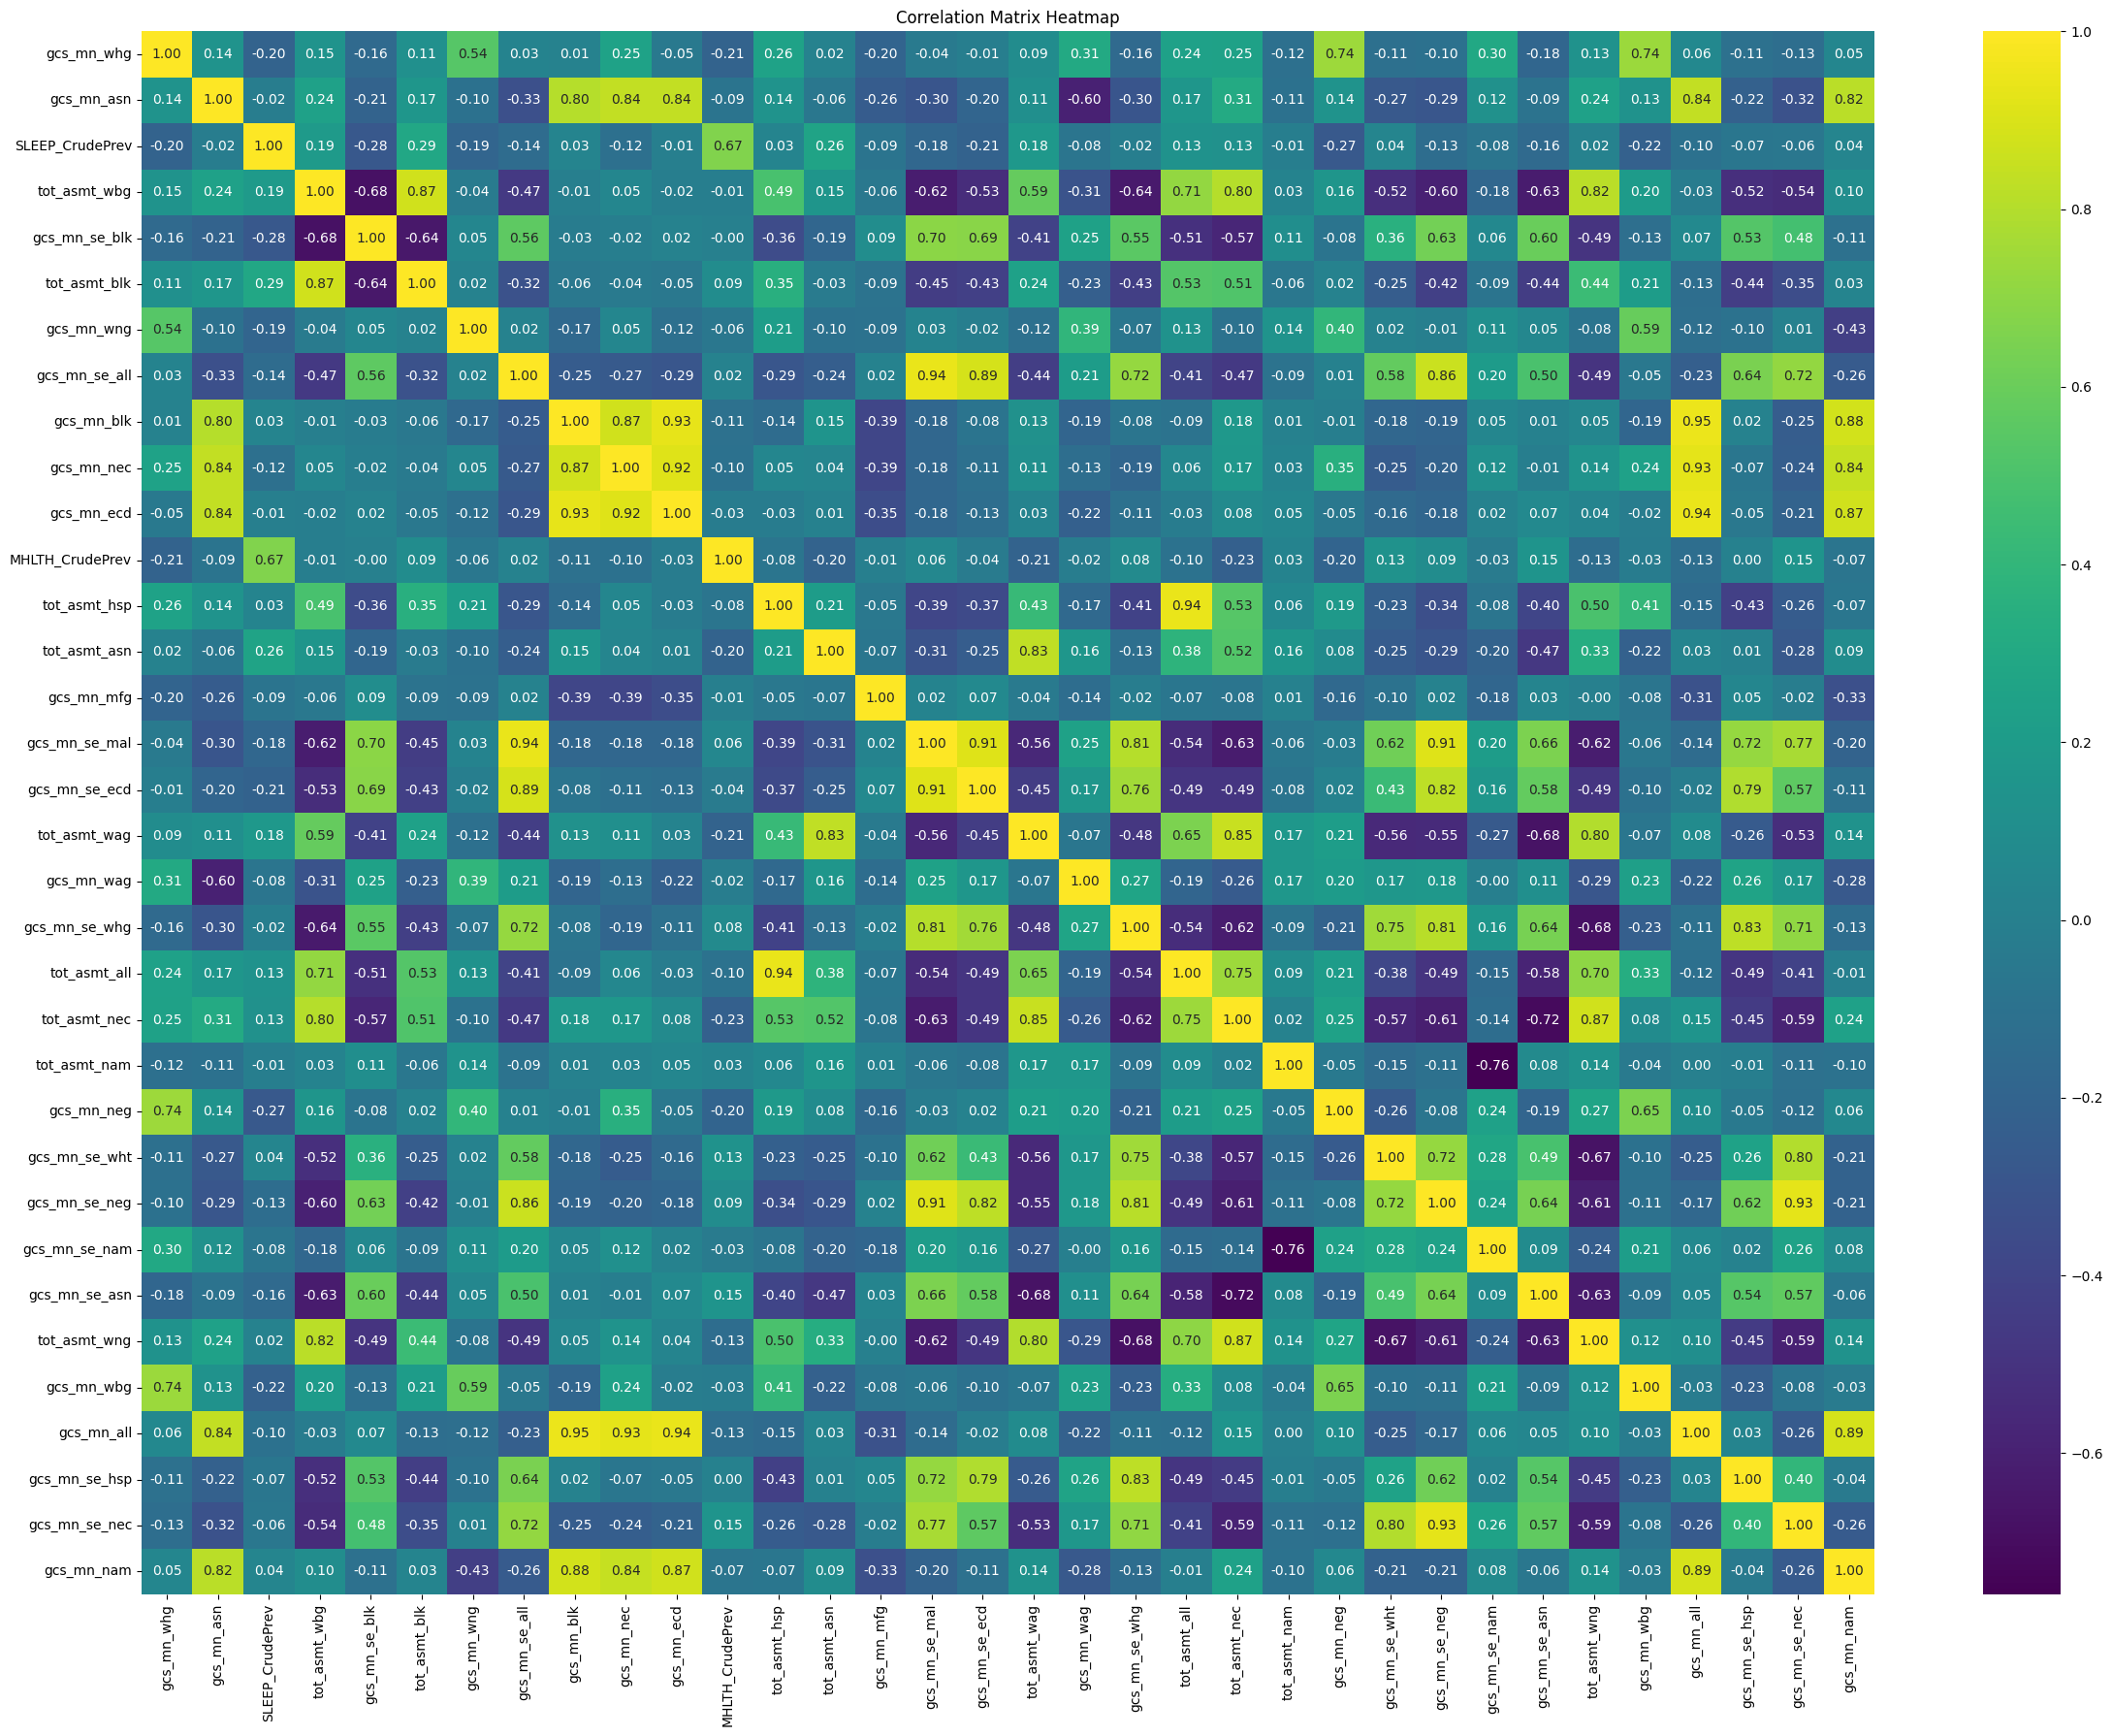

Removed: ['gcs_mn_hsp', 'gcs_mn_mal', 'tot_asmt_whg', 'gcs_mn_wht', 'gcs_mn_se_wbg', 'gcs_mn_se_mfg', 'tot_asmt_mal', 'tot_asmt_ecd', 'gcs_mn_se_wng', 'gcs_mn_se_wag', 'tot_asmt_wht', 'tot_asmt_neg', 'gcs_mn_se_fem', 'gcs_mn_fem', 'tot_asmt_fem', 'tot_asmt_mfg']


In [8]:
uncorrelated_features, correlated_features = u.de_correlate(race_df[feature_cols])
corr_map = race_df[uncorrelated_features].corr()
plt.figure(figsize=(24, 18))
sns.heatmap(corr_map, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()
print(f"Removed: {correlated_features}")

In [9]:
race_df_no_corr_mth = race_df[race_df.subject == "mth"].drop(correlated_features, axis=1)
race_df_no_corr_rla = race_df[race_df.subject == "rla"].drop(correlated_features, axis=1)
print(f"Math df length: {len(race_df_no_corr_mth)}")
print(f"Reading/Language Arts df length: {len(race_df_no_corr_rla)}")

Math df length: 45574
Reading/Language Arts df length: 48939


**XGBoost**

Dataset: Math
Baseline accuracy: 0.8354
[0.3|100000|32|1.0|1.0|0.0]	Val accuracy: 0.8858 +/- 0.0039	(1453.8488 seconds)
[0.3|100000|64|1.0|1.0|0.0]	Val accuracy: 0.8853 +/- 0.0050	(703.0565 seconds)
[0.1|100000|32|1.0|1.0|0.0]	Val accuracy: 0.8866 +/- 0.0033	(900.4208 seconds)
[0.1|100000|64|1.0|1.0|0.0]	Val accuracy: 0.8872 +/- 0.0030	(882.7626 seconds)
[0.05|100000|32|1.0|1.0|0.0]	Val accuracy: 0.8874 +/- 0.0036	(997.7535 seconds)
[0.05|100000|64|1.0|1.0|0.0]	Val accuracy: 0.8876 +/- 0.0035	(1095.4034 seconds)
Best params: (0.05, 100000, 64, 1.0, 1.0, 0.0)
Train accuracy: 0.9939
Val accuracy: 0.9204
Test accuracy: 0.9197
Train balanced accuracy: 0.9974
Val balanced accuracy: 0.8227
Test balanced accuracy: 0.8246
Train precision: 0.9941
Val precision: 0.9205
Test precision: 0.9195
Train recall: 0.9939
Val recall: 0.9204
Test recall: 0.9197
Train f1: 0.9939
Val f1: 0.9204
Test f1: 0.9196


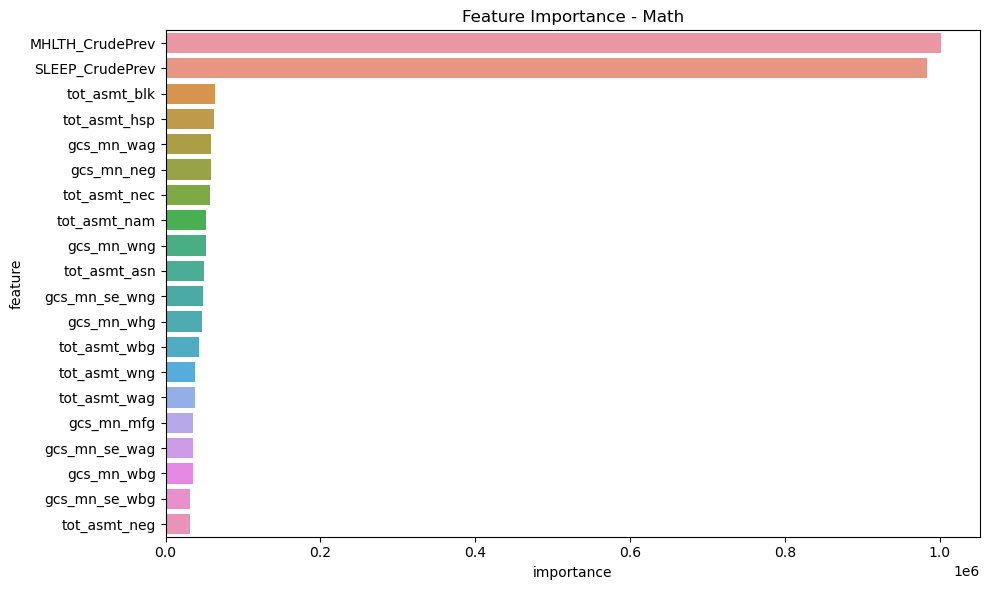

Dataset: RLA
Baseline accuracy: 0.8431
[0.3|100000|32|1.0|1.0|0.0]	Val accuracy: 0.9041 +/- 0.0024	(761.8098 seconds)
[0.3|100000|64|1.0|1.0|0.0]	Val accuracy: 0.9018 +/- 0.0014	(730.0420 seconds)
[0.1|100000|32|1.0|1.0|0.0]	Val accuracy: 0.9041 +/- 0.0017	(1005.6975 seconds)
[0.1|100000|64|1.0|1.0|0.0]	Val accuracy: 0.9038 +/- 0.0023	(1311.6810 seconds)
[0.05|100000|32|1.0|1.0|0.0]	Val accuracy: 0.9041 +/- 0.0016	(1460.7718 seconds)
[0.05|100000|64|1.0|1.0|0.0]	Val accuracy: 0.9033 +/- 0.0025	(1136.2029 seconds)
Best params: (0.05, 100000, 32, 1.0, 1.0, 0.0)
Train accuracy: 0.9944
Val accuracy: 0.9322
Test accuracy: 0.9301
Train balanced accuracy: 0.9972
Val balanced accuracy: 0.8369
Test balanced accuracy: 0.8374
Train precision: 0.9946
Val precision: 0.9319
Test precision: 0.9305
Train recall: 0.9944
Val recall: 0.9322
Test recall: 0.9301
Train f1: 0.9945
Val f1: 0.9320
Test f1: 0.9302


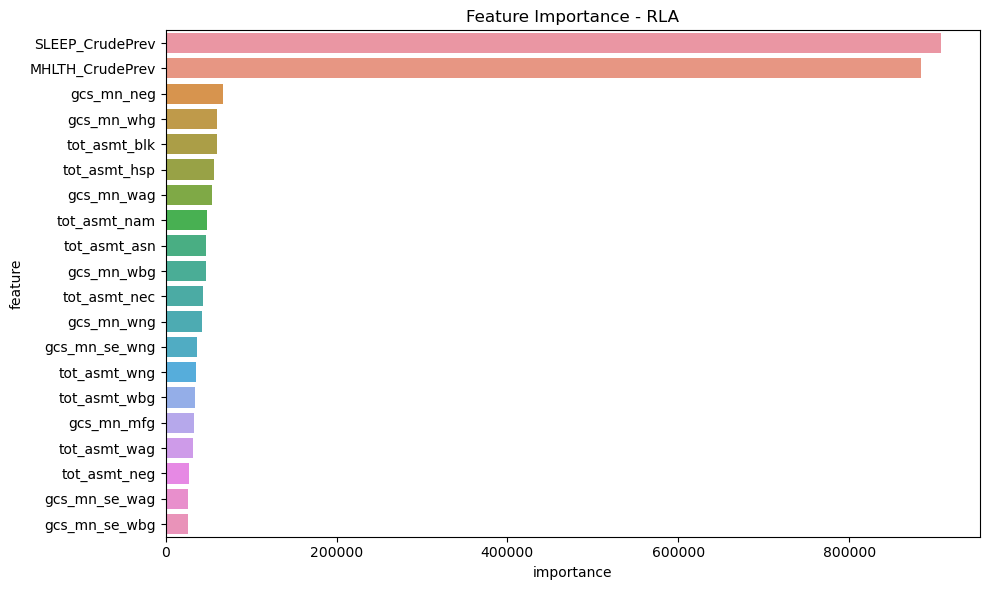

{'Math': (0.05, 100000, 64, 1.0, 1.0, 0.0), 'RLA': (0.05, 100000, 32, 1.0, 1.0, 0.0)}


In [13]:
param_grid = {
    "learning_rate": [0.3, 0.1, 0.05],
    "n_estimators": [100_000],
    "max_depth": [32, 64],
    "subsample": [1.0],
    "colsample_bytree": [1.0],
    "gamma": [0.0],
}

param_combinations = list(product(
    param_grid["learning_rate"],
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["subsample"],
    param_grid["colsample_bytree"],
    param_grid["gamma"],
))

datasets = [("Math", race_df_no_corr_mth), ("RLA", race_df_no_corr_rla)]
best_params = {
    "Math": {},
    "RLA": {}
}
for dataset in datasets:
    name, df = dataset
    print(f"Dataset: {name}")

    X = df[uncorrelated_features]

    one_hot = OneHotEncoder(sparse_output=False)
    one_hot.fit(df.y.values.reshape(-1, 1))
    num_classes = one_hot.categories_[0].shape[0]

    X_train, X_val_test, y_train, y_val_test = train_test_split(X, df.y, test_size=0.4, stratify=df.y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

    # print(f"Train: {y_train.value_counts(normalize=True)}")
    # print(f"Val: {y_val.value_counts(normalize=True)}")
    # print(f"Test: {y_test.value_counts(normalize=True)}")
    label_counts = y_train.value_counts()
    print(f"Baseline accuracy: {label_counts.max() / label_counts.sum():.4f}")

    param_results = {}
    for lr, n_estimators, max_depth, subsample, colsample, gamma in param_combinations:
        start = time.time()
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        for train_idx, val_idx in skf.split(X_train, y_train, groups=y_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
            y_cv_train, y_cv_val = y_train.iloc[train_idx].copy(), y_train.iloc[val_idx].copy()

            y_cv_train = one_hot.transform(y_cv_train.values.reshape(-1, 1))
            y_cv_val = one_hot.transform(y_cv_val.values.reshape(-1, 1))
            train_weights = compute_sample_weight(class_weight="balanced", y=y_cv_train)
            val_weights = compute_sample_weight(class_weight="balanced", y=y_cv_val)
            y_cv_train = y_cv_train.argmax(axis=1)
            y_cv_val = y_cv_val.argmax(axis=1)

            scaler = StandardScaler()
            X_cv_train = scaler.fit_transform(X_cv_train)
            X_cv_val = scaler.transform(X_cv_val)

            dtrain = xgb.DMatrix(X_cv_train, label=y_cv_train, weight=train_weights)
            dval = xgb.DMatrix(X_cv_val, label=y_cv_val, weight=val_weights)

            params = {
                "objective": "multi:softmax",
                "num_class": num_classes,
                "learning_rate": lr,
                "max_depth": max_depth,
                "subsample": subsample,
                "colsample_bytree": colsample,
                "gamma": gamma,
                "use_rmm": True,
                "verbosity": 0,
                "seed": 42,
                "n_jobs": n_jobs,
            }

            booster = xgb.train(
                params,
                dtrain,
                num_boost_round=n_estimators,
                evals=[(dval, "val")],
                early_stopping_rounds=10_000,
                verbose_eval=False,
            )

            preds = booster.predict(dval)
            cv_scores.append(accuracy_score(y_cv_val, preds))

        print(
            f"[{lr}|{n_estimators}|{max_depth}|{subsample}|{colsample}|{gamma}]\tVal accuracy: "
            f"{np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}\t({(time.time()-start):.4f} seconds)"
        )
        param_results[(lr, n_estimators, max_depth, subsample, colsample, gamma)] = np.mean(cv_scores)

    best_param = max(param_results, key=param_results.get)
    print(f"Best params: {best_param}")
    best_params[name] = best_param

    y_train = one_hot.transform(y_train.values.reshape(-1, 1))
    y_val = one_hot.transform(y_val.values.reshape(-1, 1))
    y_test = one_hot.transform(y_test.values.reshape(-1, 1))
    train_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    val_weights = compute_sample_weight(class_weight="balanced", y=y_val)
    test_weights = compute_sample_weight(class_weight="balanced", y=y_test)
    y_train = y_train.argmax(axis=1)
    y_val = y_val.argmax(axis=1)
    y_test = y_test.argmax(axis=1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    dtrain = xgb.DMatrix(X_train, label=y_train, weight=train_weights)
    dval = xgb.DMatrix(X_val, label=y_val, weight=val_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, weight=test_weights)

    params = {
        "objective": "multi:softmax",
        "num_class": num_classes,
        "use_rmm": True,
        "learning_rate": best_param[0],
        "max_depth": best_param[2],
        "subsample": best_param[3],
        "colsample_bytree": best_param[4],
        "gamma": best_param[5],
        "seed": 42,
        "verbosity": 0,
        "n_jobs": n_jobs,
    }

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=best_param[1],
        evals=[(dval, "val")],
        early_stopping_rounds=10_000,
        verbose_eval=False,
    )

    train_preds = booster.predict(dtrain)
    val_preds = booster.predict(dval)
    test_preds = booster.predict(dtest)
    print(f"Train accuracy: {accuracy_score(y_train, train_preds):.4f}")
    print(f"Val accuracy: {accuracy_score(y_val, val_preds):.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, test_preds):.4f}")

    print(f"Train balanced accuracy: {balanced_accuracy_score(y_train, train_preds, sample_weight=train_weights):.4f}")
    print(f"Val balanced accuracy: {balanced_accuracy_score(y_val, val_preds, sample_weight=val_weights):.4f}")
    print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, test_preds, sample_weight=test_weights):.4f}")

    print(f"Train precision: {precision_score(y_train, train_preds, average='weighted'):.4f}")
    print(f"Val precision: {precision_score(y_val, val_preds, average='weighted'):.4f}")
    print(f"Test precision: {precision_score(y_test, test_preds, average='weighted'):.4f}")

    print(f"Train recall: {recall_score(y_train, train_preds, average='weighted'):.4f}")
    print(f"Val recall: {recall_score(y_val, val_preds, average='weighted'):.4f}")
    print(f"Test recall: {recall_score(y_test, test_preds, average='weighted'):.4f}")

    print(f"Train f1: {f1_score(y_train, train_preds, average='weighted'):.4f}")
    print(f"Val f1: {f1_score(y_val, val_preds, average='weighted'):.4f}")
    print(f"Test f1: {f1_score(y_test, test_preds, average='weighted'):.4f}")

    importance = booster.get_score(importance_type="weight")
    importance_df = pd.DataFrame(importance.items(), columns=["feature", "importance"])
    importance_df["feature"] = importance_df["feature"].apply(lambda x: 
                                                              [int(x[1:])])
    importance_df = importance_df.sort_values(by="importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=importance_df.head(20))
    plt.title(f"Feature Importance - {name}")
    plt.tight_layout()
    plt.show()

print(best_params)



**KMeans**

In [21]:
from itertools import product
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
)
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import time

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # Manhattan and Euclidean
}

param_combinations = list(product(
    param_grid["n_neighbors"],
    param_grid["weights"],
    param_grid["p"]
))

datasets = [("Math", race_df_no_corr_mth), ("RLA", race_df_no_corr_rla)]
best_params = {name: {} for name, _ in datasets}

one_hot = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

for dataset in datasets:
    name, df = dataset
    print(f"\nDataset: {name}")

    X = df[uncorrelated_features]
    y = df.y

    one_hot.fit(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    param_results = {}
    for n_neighbors, weights, p in tqdm(
        param_combinations,
        total=len(param_combinations)
    ):
        start = time.time()
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        acc_scores, bal_acc_scores = [], []
        ari_scores, nmi_scores, homo_scores = [], [], []

        for train_idx, val_idx in skf.split(X_train, y_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            scaler = StandardScaler()
            X_cv_train = scaler.fit_transform(X_cv_train)
            X_cv_val = scaler.transform(X_cv_val)

            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
            knn.fit(X_cv_train, y_cv_train)
            val_preds = knn.predict(X_cv_val)

            # Core metrics
            acc_scores.append(accuracy_score(y_cv_val, val_preds))

            y_val_ohe = one_hot.transform(y_cv_val.values.reshape(-1, 1))
            val_weights = compute_sample_weight(class_weight="balanced", y=y_val_ohe)
            bal_acc_scores.append(balanced_accuracy_score(y_cv_val, val_preds, sample_weight=val_weights))

            # Clustering similarity metrics
            ari_scores.append(adjusted_rand_score(y_cv_val, val_preds))
            nmi_scores.append(normalized_mutual_info_score(y_cv_val, val_preds))
            h, _, _ = homogeneity_completeness_v_measure(y_cv_val, val_preds)
            homo_scores.append(h)

        mean_acc = np.mean(acc_scores)
        # print(f"Params: {n_neighbors}, {weights}, p={p} - Time: {(time.time()-start):.2f}s")
        # print(f"Accuracy: {mean_acc:.4f} ± {np.std(acc_scores):.4f}")
        # print(f"Balanced Accuracy: {np.mean(bal_acc_scores):.4f} ± {np.std(bal_acc_scores):.4f}")
        # print(f"ARI: {np.mean(ari_scores):.4f} ± {np.std(ari_scores):.4f}")
        # print(f"NMI: {np.mean(nmi_scores):.4f} ± {np.std(nmi_scores):.4f}")
        # print(f"Homogeneity: {np.mean(homo_scores):.4f}")
        # print(f"Completeness: {np.mean(comp_scores):.4f}")
        # print(f"V-measure: {np.mean(v_scores):.4f}")
        # print()

        # Use mean of core metrics as scoring basis
        param_results[(n_neighbors, weights, p)] = np.mean([
            mean_acc,
            np.mean(bal_acc_scores),
            np.mean(ari_scores),
            np.mean(nmi_scores),
            np.mean(homo_scores)
        ])

    print("_" * 30)
    best_param = max(param_results, key=param_results.get)
    print(f"Best params: {best_param}")
    best_params[name] = best_param

    # Final evaluation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    knn_final = KNeighborsClassifier(
        n_neighbors=best_param[0],
        weights=best_param[1],
        p=best_param[2]
    )
    knn_final.fit(X_train_scaled, y_train)

    for split, X_eval, y_eval in [
        ("Train", X_train_scaled, y_train),
        ("Test", X_test_scaled, y_test),
    ]:
        preds = knn_final.predict(X_eval)
        y_eval_ohe = one_hot.transform(y_eval.values.reshape(-1, 1))
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_eval_ohe)

        print(f"{split} Accuracy: {accuracy_score(y_eval, preds):.4f}")
        print(f"{split} Balanced Accuracy: {balanced_accuracy_score(y_eval, preds, sample_weight=sample_weights):.4f}")
        print(f"{split} ARI: {adjusted_rand_score(y_eval, preds):.4f}")
        print(f"{split} NMI: {normalized_mutual_info_score(y_eval, preds):.4f}")
        h, _, _ = homogeneity_completeness_v_measure(y_eval, preds)
        print(f"{split} Homogeneity: {h:.4f}")
        print()

print("\nBest parameters per dataset:")
print(best_params)



Dataset: Math


100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


______________________________
Best params: (5, 'distance', 2)
Train Accuracy: 0.9949
Train Balanced Accuracy: 0.9927
Train ARI: 0.9775
Train NMI: 0.9434
Train Homogeneity: 0.9472

Test Accuracy: 0.7963
Test Balanced Accuracy: 0.4024
Test ARI: 0.0763
Test NMI: 0.0328
Test Homogeneity: 0.0266


Dataset: RLA


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


______________________________
Best params: (5, 'uniform', 2)
Train Accuracy: 0.8578
Train Balanced Accuracy: 0.4750
Train ARI: 0.2569
Train NMI: 0.1369
Train Homogeneity: 0.1012

Test Accuracy: 0.8181
Test Balanced Accuracy: 0.3911
Test ARI: 0.0794
Test NMI: 0.0297
Test Homogeneity: 0.0223


Best parameters per dataset:
{'Math': (5, 'distance', 2), 'RLA': (5, 'uniform', 2)}
